In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx
import random
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from umap.umap_ import UMAP


# User data
 
I'm trying out different approches here: 
 - Visualising the books using the titles and applying LDA for topic extraction
 - Visualising the books using the titles and user data as metric
 - Visualising the users using common books as metric
 - Using networkx to create a network of books
 

In [4]:
user_df = pd.DataFrame()

csv_directory = 'user_data'

for filename in os.listdir(csv_directory):
    if filename.endswith(".csv"):
        year = filename.split('.')[0]
        file_path = os.path.join(csv_directory, filename)
        df = pd.read_csv(file_path, delimiter=';',encoding='ISO-8859-1',low_memory=False)
        df['Year'] = year  # Add a 'Year' column with the year value
        user_df = pd.concat([user_df, df], ignore_index=True)
        print('{}: {} entries'.format(year, len(df)))



2020: 4981 entries
2021: 9389 entries
2023: 10881 entries
2022: 12653 entries
2019: 32787 entries
2018: 50744 entries
2015: 75451 entries
2014: 74116 entries
2016: 71605 entries
2017: 62325 entries
2013: 68140 entries
2012: 3056 entries


In [5]:
user_df['Z36H_LOAN_DATE'] = pd.to_datetime(user_df['Z36H_LOAN_DATE'], format='%Y%m%d', errors='coerce')
user_df['Z36H_RETURNED_DATE'] = pd.to_datetime(user_df['Z36H_RETURNED_DATE'], format='%Y%m%d', errors='coerce')
user_df.dropna(subset=['Z36H_LOAN_DATE'], inplace=True)
user_df['Year'] = user_df['Z36H_LOAN_DATE'].dt.year

mask = user_df['Year'] == 2014
user_df.loc[mask, 'Z30_CALL_NO'] = user_df.loc[mask, 'ï»¿Z30_CALL_NO']
user_df = user_df.drop(user_df.columns[-1], axis=1)


In [6]:
user_df

,Z30_CALL_NO,Z30_COLLECTION,Z30_BARCODE,Z30_INVENTORY_NUMBER,Z30_DESCRIPTION,Z30_NO_LOANS,Z36H_LOAN_DATE,Z36H_RETURNED_DATE,Z36H_ID,Z36H_LOAN_CATALOGER_NAME,Z13_TITLE,Year
0,Ha 280-6080,BIB,E004010041AD2DFD,2014.1366,NaN,10.0,2020-08-26,2020-09-02,BHR-1048,SELFCHECK,Die Sprache der Materialien,2020
1,Va 6400-6090,MAG,E0040100413A8184,2009.4815,NaN,64.0,2020-10-22,2020-11-05,MPG000012838,SELFCHECK,The Accademia seminars,2020
2,KatM-AVI 5720-5760/a,BIB,E004010042EB1ED0,1990.2315,NaN,3.0,2020-09-24,2020-10-06,BHR-575,SELFCHECK,"Avignon, Musée du Petit Palais",2020
3,Hm 9000-6110/1,BIB,E004010043854685,2011.2460,NaN,6.0,2020-09-08,2020-09-10,BHR-1062,SELFCHECK,Handbuch der politischen Ikonographie,2020
4,Cm-PON 7500-6112/1,BIB,E004010042EB5DA0,2012.645,NaN,1.0,2020-06-09,2022-02-28,BHR-980,SELFCHECK,Espressioni di Gio Ponti,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
476123,Mb 705-6122,BIB,E00401004375E7E2,2012.3083,NaN,24.0,2012-11-22,2013-02-05,MPG000012275,WWW-OPAC,Katholische Bildertheologie der frühen Neuzeit,2012
476124,Ca-LAZ 9713-6110,BIB,E004010043851BD1,2012.1979,NaN,4.0,2012-08-31,2012-08-31,MPG000012326,WWW-OPAC,Lo studio Lazzerini,2012
476125,Ff 95-6110,BIB,E004010043762C93,2012.1985,NaN,1.0,2012-09-28,2012-09-28,MPG000012326,SELFCHECK,Viaggio del marchese Nicolo D'Este al Santo Se...,2012
476126,Bn 621-6120,BIB,E00401004382E07D,2012.3155,NaN,2.0,2012-11-28,2013-01-02,MPG000012567,SELFCHECK,Architettura e arti applicate negli anni Cinqu...,2012


## User data analysis

In [7]:
print('Unique users in dataset: {}'.format(user_df.Z36H_ID.unique().size))

Unique users in dataset: 768


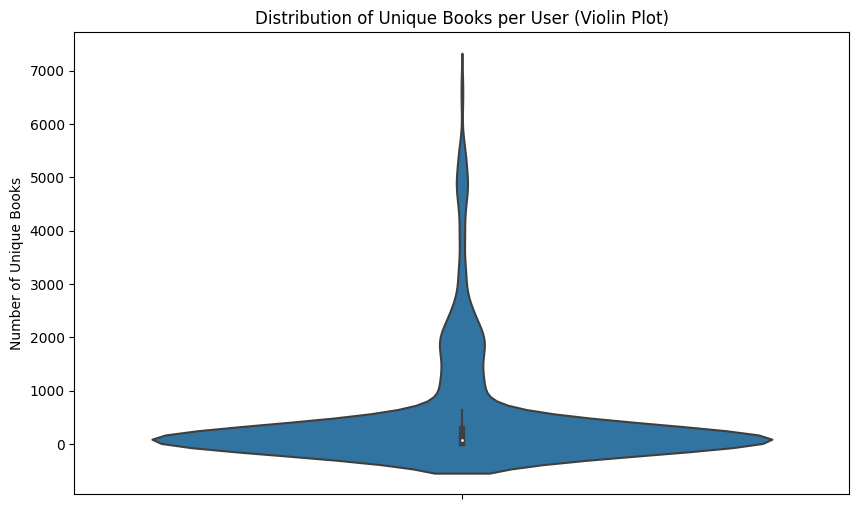

In [8]:
user_book_counts = user_df.groupby('Z36H_ID')['Z30_CALL_NO'].nunique()

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(y=user_book_counts)
plt.title('Distribution of Unique Books per User (Violin Plot)')
plt.ylabel('Number of Unique Books')
plt.show()

In [9]:


# Are top users internal? 
top_users = user_book_counts.sort_values(ascending=False).head(100)
bhr_users = top_users[top_users.index.str.startswith('BHR')]

print(f"Percentage of 'BHR' Users in Top 100: {bhr_users.count()/100:.2f}%")


Percentage of 'BHR' Users in Top 100: 0.00%


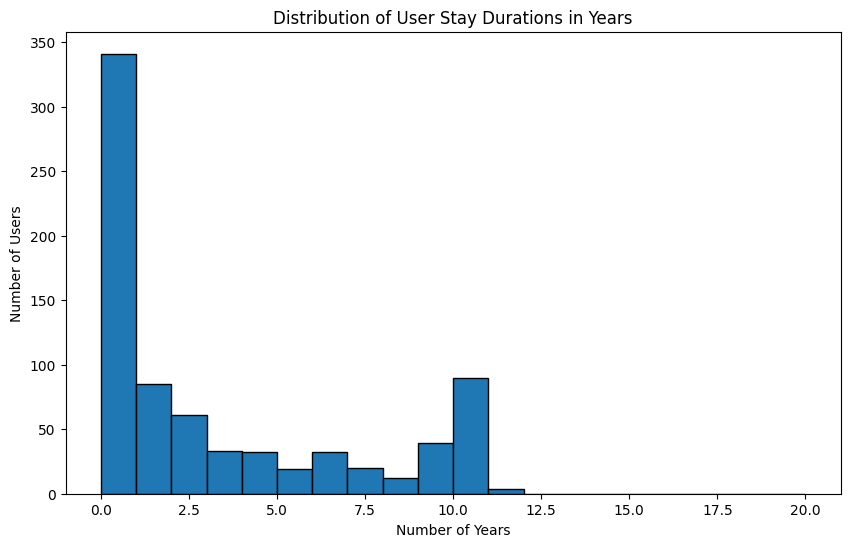

In [10]:
# Calculate the first and last loan dates for each user
user_first_loan_date = user_df.groupby('Z36H_ID')['Z36H_LOAN_DATE'].min()
user_last_loan_date = user_df.groupby('Z36H_ID')['Z36H_LOAN_DATE'].max()

# Calculate the duration of stay in the library for each user in years
user_stay_duration_years = (user_last_loan_date - user_first_loan_date).dt.days // 365

# Create a histogram to visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(user_stay_duration_years, bins=20, edgecolor='k', range=(0, 20))  # Adjust the range as needed
plt.title('Distribution of User Stay Durations in Years')
plt.xlabel('Number of Years')
plt.ylabel('Number of Users')
plt.show()

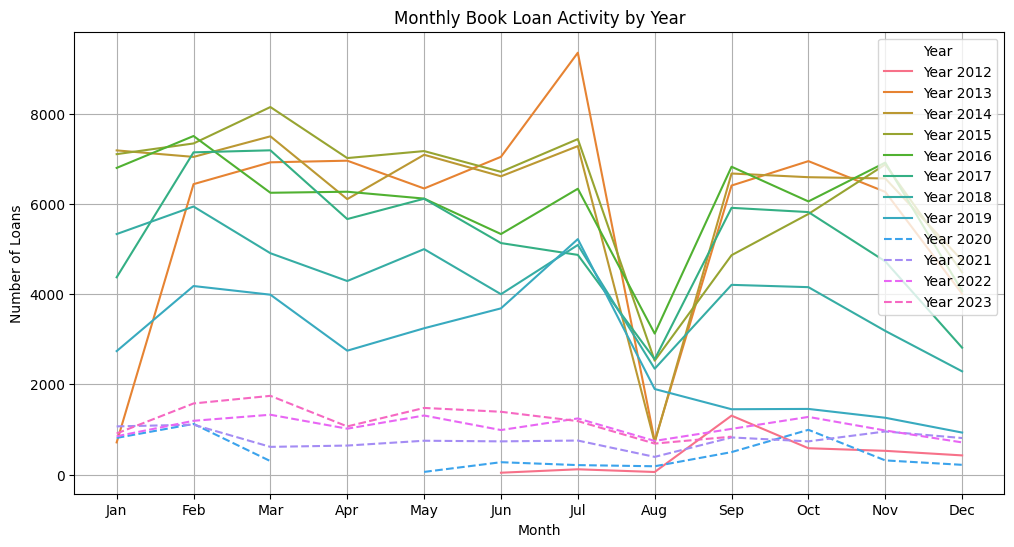

In [11]:

# Map books over time (e.g. a year, when is the library most active, when not so much)
loan_counts = user_df.groupby(['Year', user_df['Z36H_LOAN_DATE'].dt.month])['Z30_CALL_NO'].count().unstack()

# Create a line plot for each year with conditional line styles
plt.figure(figsize=(12, 6))
sns.set_palette("husl", len(loan_counts.index))
for year in loan_counts.index:
    linestyle = '-' if year <= 2019 else '--'  # Dotted line for years after 2019
    plt.plot(loan_counts.columns, loan_counts.loc[year], label=f'Year {year}', linestyle=linestyle)

plt.title('Monthly Book Loan Activity by Year')
plt.xlabel('Month')
plt.ylabel('Number of Loans')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Year', loc='upper right')
plt.show()

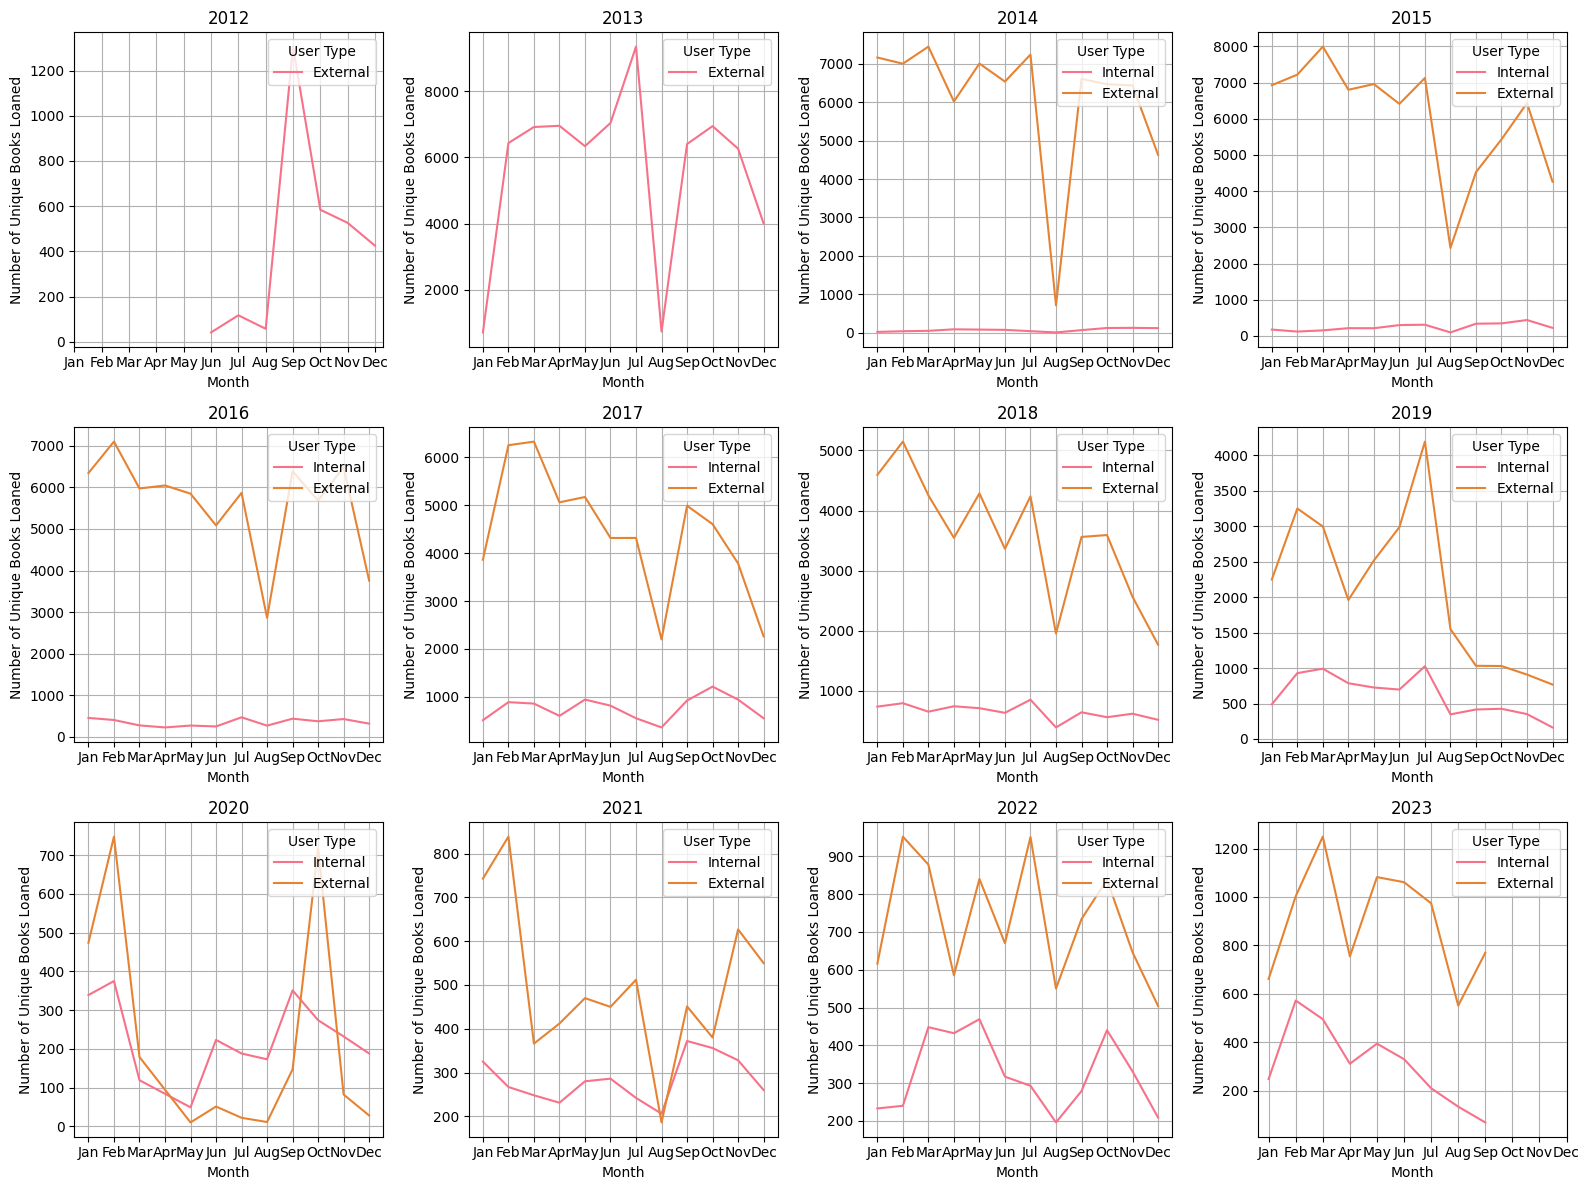

In [12]:
# Create a new column 'UserType' to categorize users as internal or external
user_df['UserType'] = user_df['Z36H_ID'].apply(lambda x: 'Internal' if x.startswith('BHR') else 'External')

# Group the data by 'Year', 'Month', and 'UserType' and calculate the count of loans
loan_counts = user_df.groupby(['Year', user_df['Z36H_LOAN_DATE'].dt.month, 'UserType'])['Z30_CALL_NO'].count()

# Get unique years from the data
unique_years = loan_counts.index.get_level_values('Year').unique()

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, year in enumerate(unique_years):
    row, col = i // 4, i % 4
    ax = axes[row, col]

    data_year = loan_counts.loc[year].reset_index()

    # Filter data for internal and external users separately
    internal_data = data_year[data_year['UserType'] == 'Internal']
    external_data = data_year[data_year['UserType'] == 'External']

    # Set the palette for consistent colors
    sns.set_palette("husl", 2)

    # Create line plots for internal and external users
    sns.lineplot(data=internal_data, x='Z36H_LOAN_DATE', y='Z30_CALL_NO', label='Internal', ax=ax)
    sns.lineplot(data=external_data, x='Z36H_LOAN_DATE', y='Z30_CALL_NO', label='External', ax=ax)

    ax.set_title(f'{year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Unique Books Loaned')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid(True)
    ax.legend(title='User Type', loc='upper right')

# To ensure proper spacing
plt.tight_layout()
plt.show()





In [42]:
# Merge data with book metadata
freihand_path = 'data/hertziana_exp/freihand_signatures.csv'
freihand = pd.read_csv(freihand_path)

#Join with Freihand dataset to get more info 
merged_df = user_df.merge(freihand, left_on='Z30_CALL_NO', right_on='signature', how='inner')
print(merged_df.groupby('lang')['bvb'].count().sort_values(ascending=False))

merged_df.to_csv('user_data/merged.csv', index=False)

#dataframes for top 4 langs
eng = merged_df[merged_df.lang == 'eng']
ita = merged_df[merged_df.lang == 'ita']
ger = merged_df[merged_df.lang == 'ger']
fre = merged_df[merged_df.lang == 'fre']

lang
ita    164137
eng     41553
ger     22131
fre     10309
und      1441
lat      1430
spa      1305
dut       251
gre       118
cat        96
por        92
rum        88
pol        78
rus        60
hrv        46
mul        38
cze        32
srp        30
swe        29
dan        29
lit        27
hun        22
jpn        18
grc        16
gmh        13
fin         9
slv         8
bul         6
arm         5
slo         5
nor         4
nep         3
scr         2
geo         2
tur         1
baq         1
heb         1
mac         1
ara         1
Name: bvb, dtype: int64


In [14]:
# How many different books

# map languages of books

# Do users get books only in one language or multiple? 

# How long are users there, do they come back etc.?

In [15]:
subject_dict= {'A': 'Manuals', 'B': 'Italian Art', 'C': 'Italian Artists', 'D': 'Rome','E':'Italian Topography', 'F': 'Travel Literature', 
               'G': 'Sources', 'H': 'Iconography', 'J': 'Ornament','K': 'Kat and K', 'L': 'Congress Publications', 'M': 'Art in General',
                'N': 'Architecture', 'O':'Sculpture', 'P': 'Painting', 'Q': 'Manuscript Illumination', 'R': 'Graphic Arts', 
               'S': 'Applied Arts', 'T': 'Collecting Art, Museum Studies', 'U': 'Registers of Artistic Monuments', 'V': 'Cultural Institutions', 
               'W': 'Non-Italian Artists','X': 'European Topography', 'Y': 'World Topography', 'Z': 'Related Disciplines', ' ': 'None'}


custom_colours = ["#EA522B", "#EFD4D1", "#2A4978", "#8BDBE1", "#ECA19D", "#B48E36", "#E1DCE0", "#B8BFCE", "#E0DCD1", "#91C5E4", 
                  "#6E8EAC", "#D2E7E0", "#ECD096", "#6C9686", "#E6E10F", "#9D4B37", "#A3B49D", "#BDC920", "#DBE3E5", "#6A8B8D", "#EFB3D1"]
custom_cmap = ListedColormap(custom_colours)

In [16]:
eng.columns

Index(['Z30_CALL_NO', 'Z30_COLLECTION', 'Z30_BARCODE', 'Z30_INVENTORY_NUMBER',
       'Z30_DESCRIPTION', 'Z30_NO_LOANS', 'Z36H_LOAN_DATE',
       'Z36H_RETURNED_DATE', 'Z36H_ID', 'Z36H_LOAN_CATALOGER_NAME',
       'Z13_TITLE', 'Year', 'UserType', 'bvb', 'title', 'signature',
       'inventory_nr', 'inventory_date', 'inventory_year', 'lang', 'year',
       'sys', 'text', 'text_1', 'text_2', 'text_3', 'sig_lev_1', 'sig_lev_2'],
      dtype='object')

In [17]:
eng

,Z30_CALL_NO,Z30_COLLECTION,Z30_BARCODE,Z30_INVENTORY_NUMBER,Z30_DESCRIPTION,Z30_NO_LOANS,Z36H_LOAN_DATE,Z36H_RETURNED_DATE,Z36H_ID,Z36H_LOAN_CATALOGER_NAME,...,inventory_year,lang,year,sys,text,text_1,text_2,text_3,sig_lev_1,sig_lev_2
20,Cm-PON 7500-6112/1,BIB,E004010042EB5DA0,2012.645,NaN,1.0,2020-06-09,2022-02-28,BHR-980,SELFCHECK,...,2012.0,eng,2011.0,Cm-PON 7500,"Ponti,_Gio",Italienische_Künstler,Moderne_Künstler_(geboren_nach_1870),NaN,C,Cm
142,Mb 705-6113,BIB,E0040100441E533C,2014.4647,NaN,17.0,2020-01-22,2022-12-19,MPG000012293,WWW-OPAC,...,2014.0,eng,2011.0,Mb 705,Kunst_und_Religion,Kunst_allgemein_(ohne_Italien_speziell),Theoretische_Grundlagen_und_Randgebiete_der_Ku...,Motivgeschichtliche_Monographien,M,Mb
143,Mb 705-6113,BIB,E0040100441E533C,2014.4647,NaN,17.0,2019-07-17,2019-07-18,MPG000012840,SELFCHECK,...,2014.0,eng,2011.0,Mb 705,Kunst_und_Religion,Kunst_allgemein_(ohne_Italien_speziell),Theoretische_Grundlagen_und_Randgebiete_der_Ku...,Motivgeschichtliche_Monographien,M,Mb
144,Mb 705-6113,BIB,E0040100441E533C,2014.4647,NaN,17.0,2019-07-18,2019-07-19,MPG000012848,SELFCHECK,...,2014.0,eng,2011.0,Mb 705,Kunst_und_Religion,Kunst_allgemein_(ohne_Italien_speziell),Theoretische_Grundlagen_und_Randgebiete_der_Ku...,Motivgeschichtliche_Monographien,M,Mb
145,Mb 705-6113,BIB,E0040100441E533C,2014.4647,NaN,17.0,2019-07-15,NaT,MPG000012826,SELFCHECK,...,2014.0,eng,2011.0,Mb 705,Kunst_und_Religion,Kunst_allgemein_(ohne_Italien_speziell),Theoretische_Grundlagen_und_Randgebiete_der_Ku...,Motivgeschichtliche_Monographien,M,Mb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402019,Br 425-5380/4,BIB,E0040100413A66C2,NaN,NaN,1.0,2012-09-08,2014-03-28,MPG000012303,SELFCHECK,...,NaN,eng,1938.0,Br 425,Anfänge_des_Holz-_und_Metallschnitts_(15._Jh.)...,Italienische_Kunst,Graphik,Geschichte_der_Graphik_nach_Gattungen,B,Br
402021,Br 255-5030/2 gr,BIB,E00401080E88A790,NaN,NaN,1.0,2012-10-22,2013-02-27,MPG000012474,WWW-OPAC,...,NaN,eng,1903.0,Br 255,"Geschichte_der_Handzeichnung_in_der_Neuzeit,_M...",Italienische_Kunst,Graphik,Geschichte_der_Graphik_nach_Gattungen,B,Br
402160,E-TIV 12-5080,BIB,E004010042EDC0CB,NaN,NaN,1.0,2012-10-21,2016-01-25,MPG000012265,WWW-OPAC,...,NaN,eng,1908.0,E-TIV 12,kunstgeschichtliche_Literatur,Topographie_Italien_(ohne_Rom),Tivoli,NaN,E,E-
402183,Xr-SAN 3982-6020 gr,BIB,E0040100438583C0,2012.229,NaN,2.0,2012-07-19,2012-07-19,MPG000012251,SELFCHECK,...,2012.0,eng,2002.0,Xr-SAN 3982,kunstgeschichtliche_Literatur,Topographie_Europa_(ohne_Italien),Europäische_Sowjetunion_(einschließlich_baltis...,Sankt_Petersburg,X,Xr


### Topic extraction from titles using LDA (try out with english)

In [33]:
df = eng

# #spacy model eng
# nlp = spacy.load('en_core_web_sm')

# # Tokenize and unstopword titles (is_alpha = alphabetic)
# def preprocess(title):
#     doc = nlp(title)
#     tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
#     return " ".join(tokens)

# titles = [preprocess(title) for title in df.Z13_TITLE]

#tf-idf the titles 
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1), stop_words= 'english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df.Z13_TITLE)

In [36]:
# Latent Dirichlet Allocation for topic extraction

num_topics = 20 
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

topic_assignments = lda.transform(tfidf_matrix).argmax(axis=1)

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(", ".join(top_words))

Topic 1:
antiquity, ravenna, late, tomb, renaissance, german, art, raphael, mannerism, 1400
Topic 2:
power, painters, book, drawing, memory, renaissance, art, vatican, science, bartolomeo
Topic 3:
sculpture, renaissance, pictures, sacchi, artists, maria, andrea, pirro, ligorio, antique
Topic 4:
andrea, del, sarto, self, portraiture, renaissance, art, interior, perino, vaga
Topic 5:
early, modern, rome, sculpture, art, medieval, painting, century, identity, parmigianino
Topic 6:
art, renaissance, patronage, sixteenth, court, reformation, italy, century, medici, italian
Topic 7:
private, bibliographical, repertory, collections, italian, seventeenth, roman, time, palaces, rome
Topic 8:
genoa, sea, history, art, neapolitan, rosa, salvator, english, dictionary, collectors
Topic 9:
saint, zuccaro, taddeo, federico, monastery, christian, culture, catherine, sinai, mount
Topic 10:
rome, carracci, annibale, antonio, architectural, drawings, giovanni, da, circle, sangallo
Topic 11:
dutch, 1700, 

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


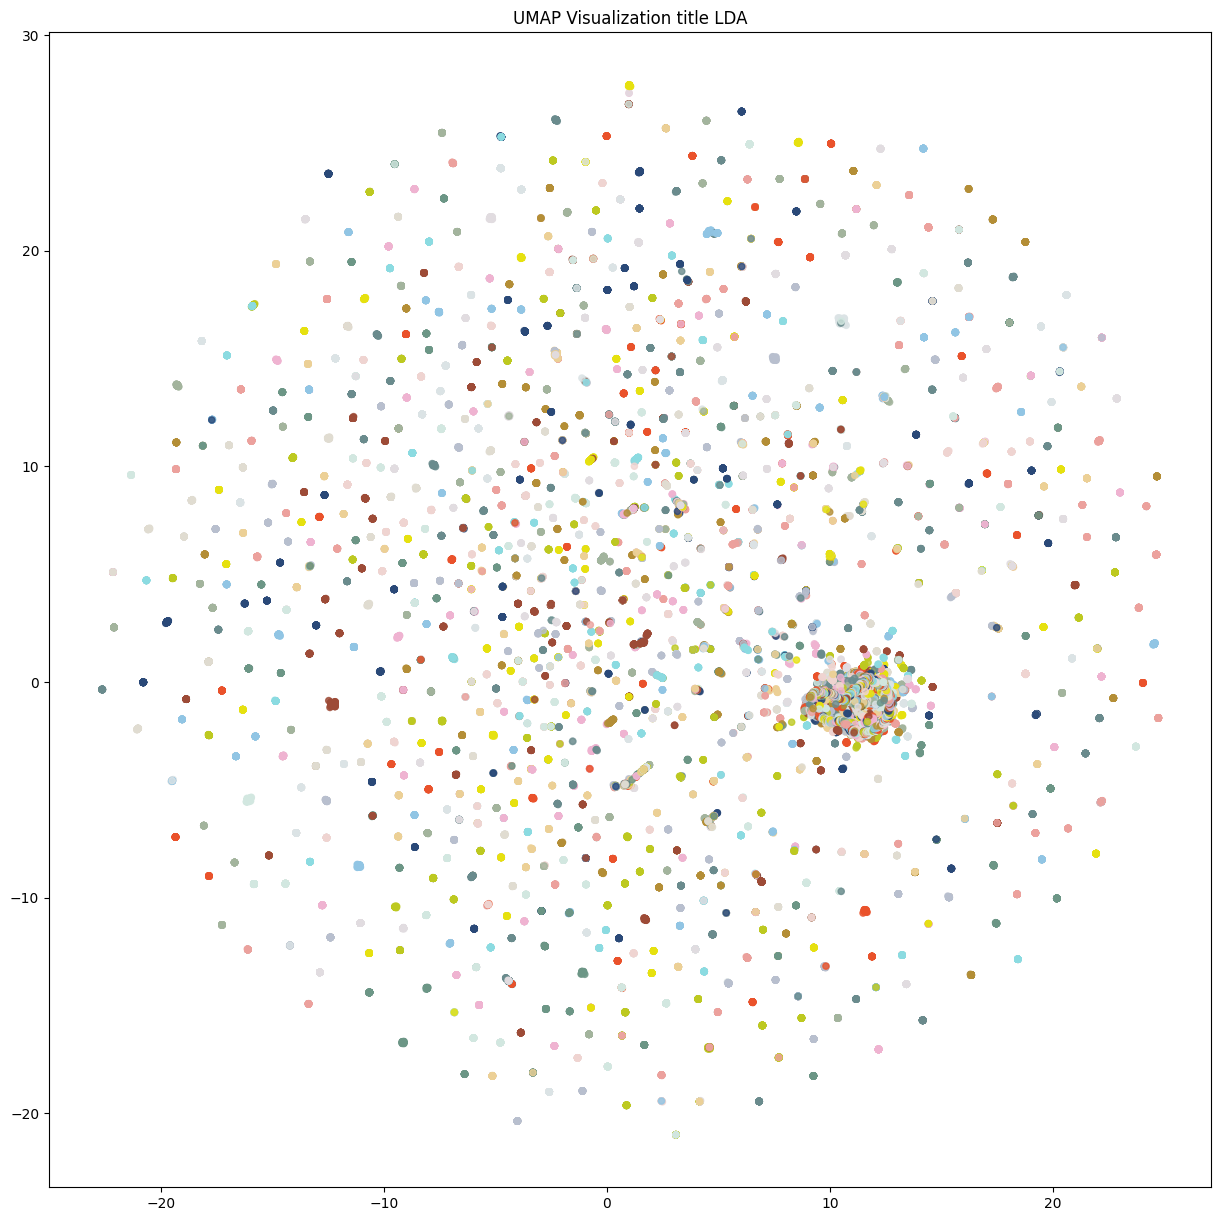

In [38]:
#embedding
umap = UMAP(n_components=2)
emb = umap.fit_transform(tfidf_matrix)

viz = pd.DataFrame({
    # 'title': titles, 
    'topic': topic_assignments, 
    'X': emb[:,0], 
    'Y': emb[:,1]
})
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(viz.X, viz.Y, s=20, alpha=0.8, c=viz.topic, cmap=custom_cmap)
plt.title('UMAP Visualization title LDA')
plt.show()

### Use titles and user data for umap

In [23]:
#one hot encode the user data
one_hot_encoded = pd.get_dummies(df[['Z30_CALL_NO', 'Z36H_ID', 'Z13_TITLE', 'sig_lev_1']], columns=['Z36H_ID'])
aggregated = one_hot_encoded.groupby('Z30_CALL_NO').max()

In [24]:
aggregated

,Z13_TITLE,sig_lev_1,Z36H_ID_12,Z36H_ID_BHR-100,Z36H_ID_BHR-1000,Z36H_ID_BHR-1007,Z36H_ID_BHR-1008,Z36H_ID_BHR-101,Z36H_ID_BHR-1011,Z36H_ID_BHR-1012,...,Z36H_ID_MPG000013396,Z36H_ID_MPG000013406,Z36H_ID_MPG000013408,Z36H_ID_MPG000013414,Z36H_ID_MPG000013432,Z36H_ID_MPG000013469,Z36H_ID_MPG000013483,Z36H_ID_MPG000013525,Z36H_ID_MPG000013532,Z36H_ID_MPG000013536
Z30_CALL_NO,,,,,,,,,,,,,,,,,,,,,
Aa 110-5700,How to find out about Italy,A,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Aa 200-6071/2,Encyclopaedic prosopographical lexicon of Byza...,A,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Aa 200-6071/3,Encyclopaedic prosopographical lexicon of Byza...,A,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Aa 234-4490/60,Who's who,A,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Aa 234-4850/c1,The dictionary of national biography,A,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yc-BET 3090-5100 gr,The Church of the nativity at Bethlehem,Y,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Yp-SIN 326-5730/1 gr,The Monastery of Saint Catherine at Mount Sina...,Y,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Yp-SIN 326-5760/1 gr,The Monastery of Saint Catherine at Mount Sina...,Y,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
#tf-idf the titles
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), stop_words= 'english')
features = tf.fit_transform(aggregated['Z13_TITLE'])

In [26]:
# Concatenate the TF-IDF and one-hot encoded data horizontally
one_hot_data = aggregated.drop(columns=['Z13_TITLE', 'sig_lev_1']).values
combined_data = np.hstack((features.toarray(), one_hot_data))
sig_lev_1_labels = aggregated['sig_lev_1']

In [27]:
umap = UMAP(n_components=2).fit_transform(features)

# Create a mapping from labels to color indices
label_to_color_index = {label: idx for idx, label in enumerate(np.unique(sig_lev_1_labels))}

# Map labels to color indices
color_indices = np.array([label_to_color_index[label] for label in sig_lev_1_labels])



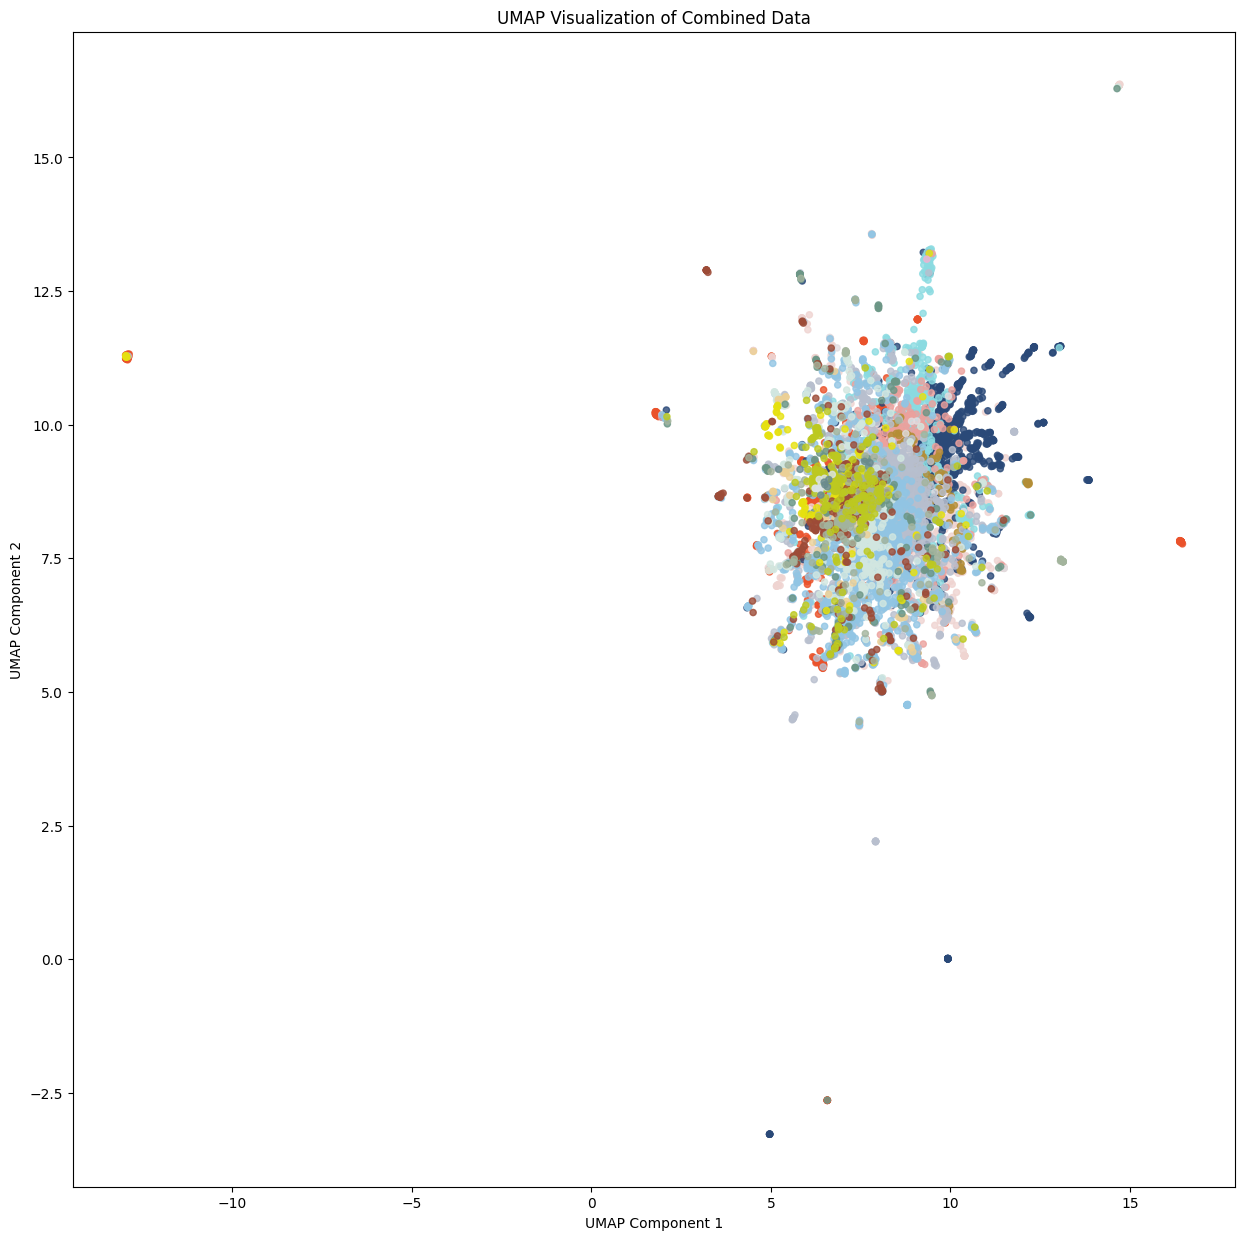

In [28]:
# Create a scatter plot to visualize the reduced-dimensional data
fig, ax = plt.subplots(figsize=(15, 15))

plt.scatter(umap[:, 0], umap[:, 1], s=20, alpha=0.8, c=color_indices, cmap=custom_cmap)
plt.title('UMAP Visualization of Combined Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

## Mapping users using books

In [21]:
#one hot encode the user data
one_hot_encoded = pd.get_dummies(df[['Z30_CALL_NO', 'Z36H_ID']], columns=['Z30_CALL_NO'])
aggregated = one_hot_encoded.groupby('Z36H_ID').max()

In [23]:
umap = UMAP(n_components=2).fit_transform(aggregated.values)

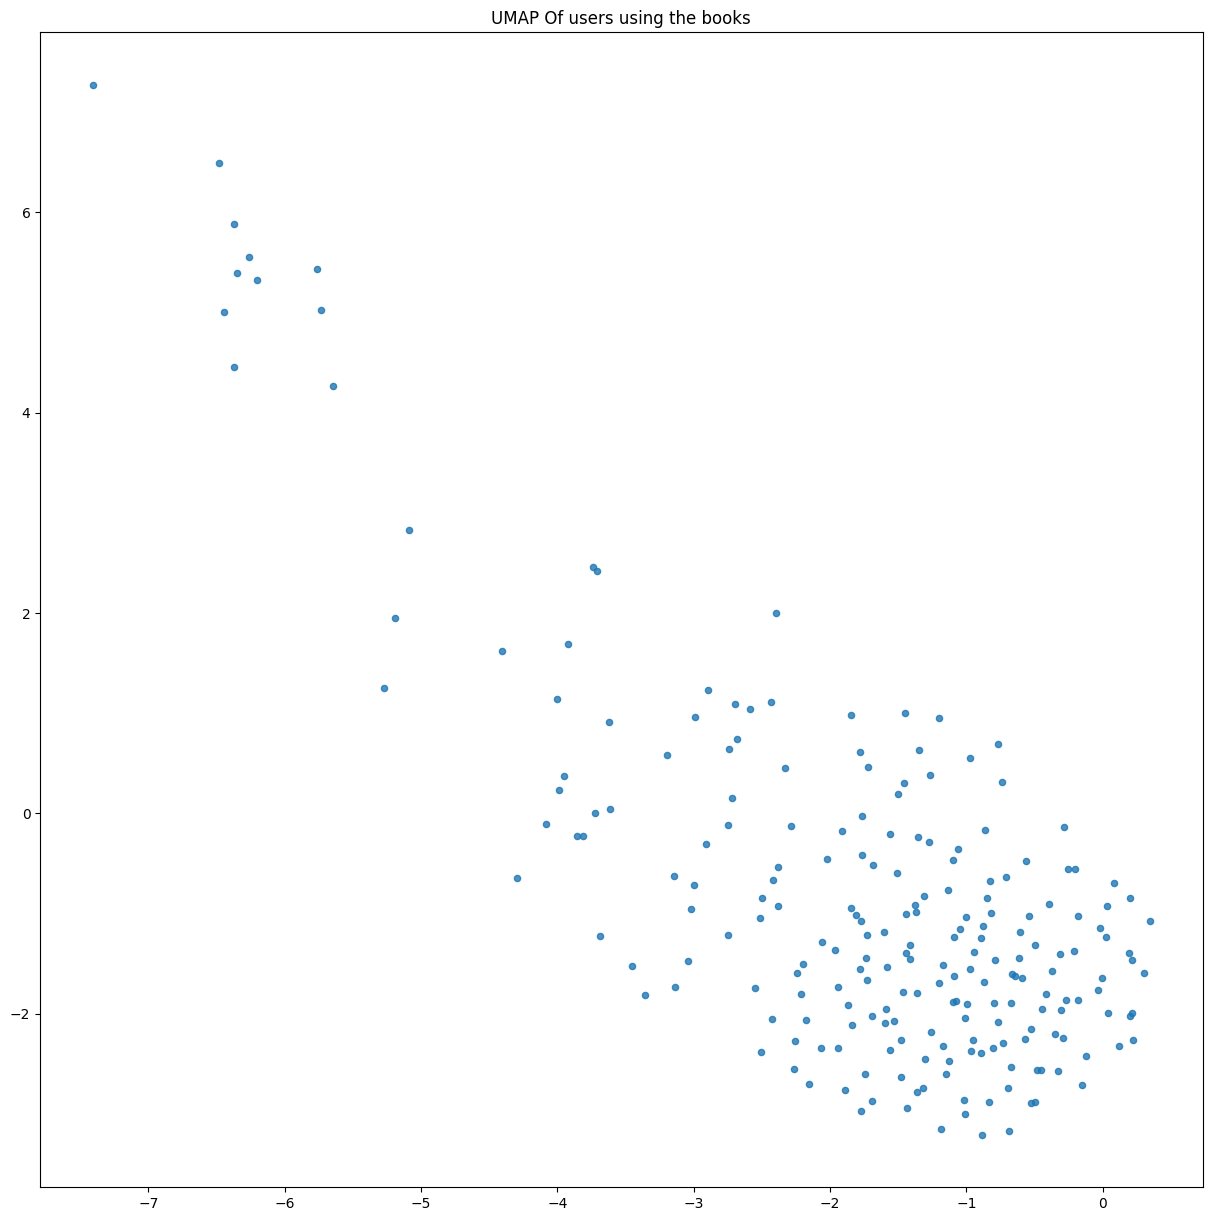

In [26]:
# Create a scatter plot to visualize the reduced-dimensional data
fig, ax = plt.subplots(figsize=(15, 15))

plt.scatter(umap[:, 0], umap[:, 1], s=20, alpha=0.8)
plt.title('UMAP Of users using the books')
plt.show()


### Networkx

I don't this is working well, but it was worth a little exploration

In [12]:
df = eng
G = nx.Graph()

for _, row in df.iterrows():
    user = row['Z36H_ID']
    book = row['Z30_CALL_NO']

    # Add an edge between books if the same user has read both
    books_read_by_user = df[df['Z36H_ID'] == user]['Z30_CALL_NO'].tolist()
    for other_book in books_read_by_user:
        if book != other_book:
            G.add_edge(book, other_book)

print('number of edges: {}'.format(G.number_of_edges()))
print('number of nodes: {}'.format(G.number_of_nodes()))

number of edges: 97116
number of nodes: 2271


/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_1010/86672361.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_nodes = random.sample(G.nodes, k=min(num_nodes_to_display, len(G.nodes)))


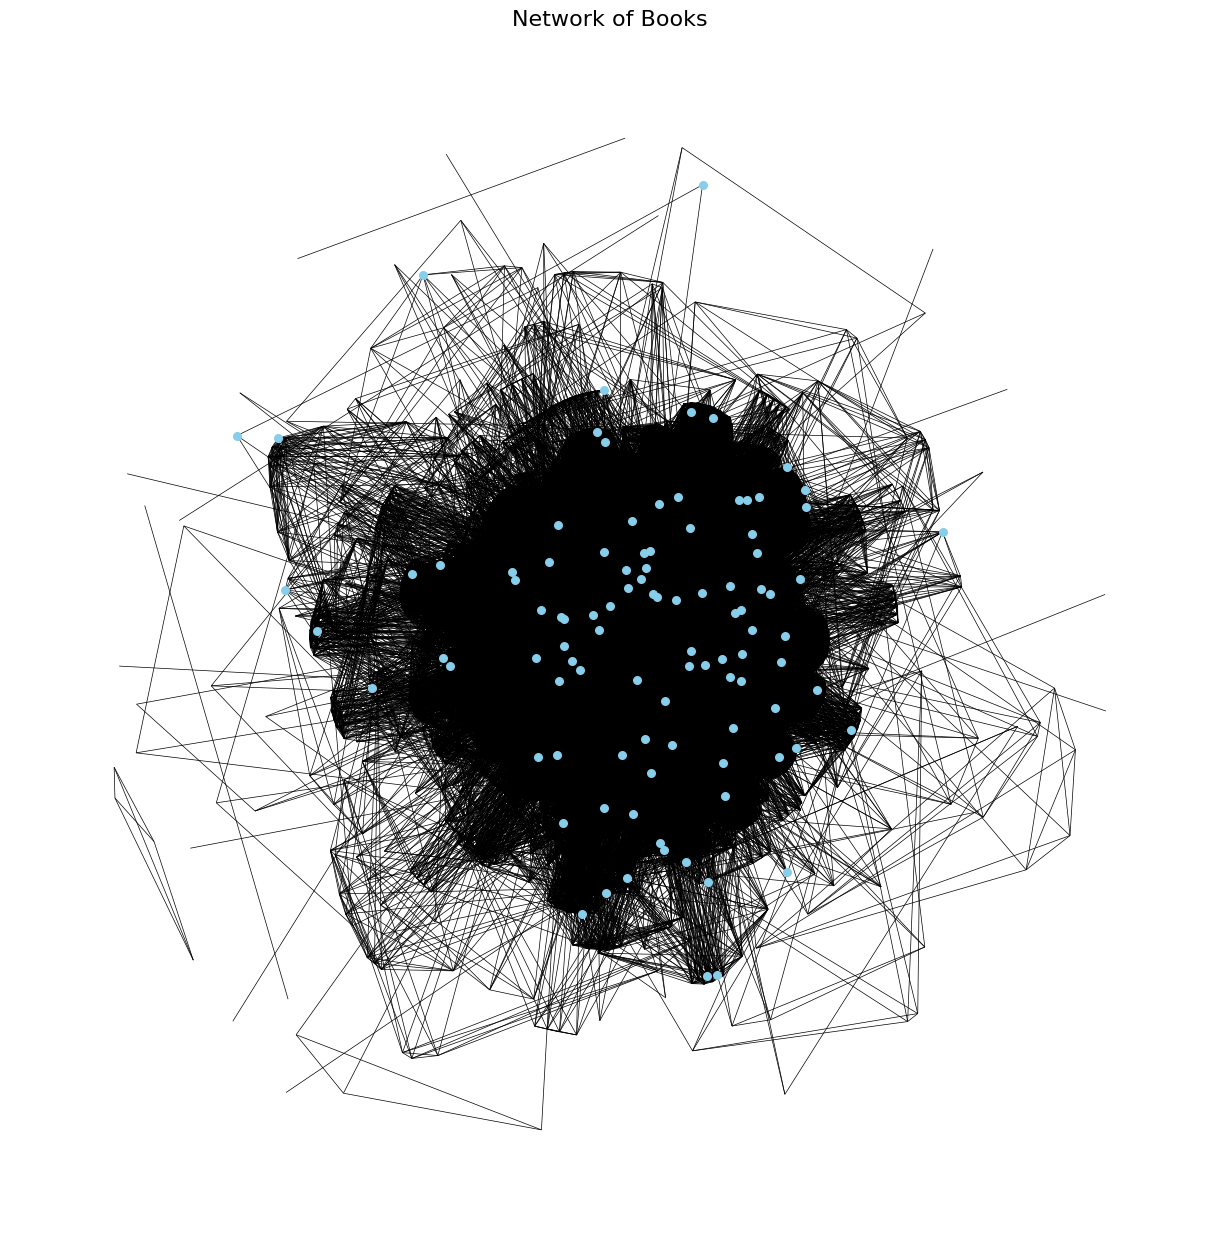

In [13]:
# Reduce the number of nodes for visualization (e.g., take a random subset)
num_nodes_to_display = 100
random_nodes = random.sample(G.nodes, k=min(num_nodes_to_display, len(G.nodes)))

# Customize the layout and appearance
pos = nx.spring_layout(G, seed=42, k=0.25, iterations=50)  # Adjust 'k' and 'iterations' for better dispersion

# Customize node and edge appearance
node_size = 30
edge_width = 0.5

# Visualize the network graph
plt.figure(figsize=(12, 12))  # Adjust the figure size as needed
nx.draw(G, pos, with_labels=False, node_size=node_size, node_color='skyblue', font_color='black', nodelist=random_nodes, width=edge_width)
plt.title("Network of Books", fontsize=16)
plt.axis('off')  # Turn off axis labels
plt.show()